<a href="https://colab.research.google.com/github/rromerov/Proyecto_Integrador/blob/main/Avance4/Avance4.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Aplicación de Modelos de Machine Learning y Acoplamiento Molecular en el Diseño Acelerado de Fármacos, propuesta contra la Viruela del Simio (MPOX). Enfoque en la Proteína F13; con Datos Experimentales Limitados.**

### Avance 4: Modelos Alternativos

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Carlos Alberto Brizuela Rodríguez  – Profesor Tutor

#### **Miembro del equipo:**
- Carlos Mario Larrahondo Valencia - A01794031



---


### Modelos Alternativos




---

### Código para el modelo

Se importan las librerías necesarias y se instalan los paquetes de Python

In [1]:
# Instalación bayesian-optimization
%%capture
! pip install scikit-optimize
! pip install lazypredict

In [2]:
! pip install scikit-optimize

In [4]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import learning_curve
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

from skopt import gp_minimize
from skopt.space import Integer, Real
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, explained_variance_score, max_error, median_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
import lazypredict
from lazypredict.Supervised import LazyRegressor

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

Conexión con el Drive para extraer los datos generados

In [5]:
# Cargar Google Drive al notebook
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Cargar el dataset
ruta_archivo_bioactivity = '/content/drive/My Drive/Colab Notebooks/data/bioactivity_data_2class_pIC50_pubchem_fp.csv'

# Lee el archivo CSV en un DataFrame
df_bioactivity = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df_bioactivity.head(5)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.39
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.27
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.37
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.60
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.48


#### Validacion de las caracteristicas y la etiqueta

Se realiza la validación y preparacion de las correspondientes caracteristicas que se han determinado a través de los fingerprints y la etiqueta correspondiente al pIC50 hallado.


In [7]:
# Se define conjunto X para las etiquetas
X = df_bioactivity.drop('pIC50', axis=1)
# Mostrar contenido en el conjunto de X
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
208,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
209,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
210,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Se determina cual es la variable objetivo, la cual se esta determinado el valor de pIC50 de la bioactividad de las moleculas


In [8]:
# Se define variable Y para el objetivo
Y = df_bioactivity.pIC50
# Mostrar contenido en el conjunto de Y
Y

,pIC50
0,0.39
1,0.27
2,0.37
3,0.60
4,0.48
...,...
207,0.92
208,0.62
209,0.28
210,0.64


#### Dimensión de las variables



In [9]:
# Dimensiones de las variables predictoras
X.shape

(212, 881)

In [10]:
# Dimensiones de la variable predicha
Y.shape

(212,)

Eliminamos columnas con baja varianza


In [11]:
# Creamos un objeto VarianceThreshold con el umbral definido
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
# Transformamos la matriz de características X utilizando el objeto VarianceThreshold
X = selection.fit_transform(X)

In [12]:
# Dimensiones de las variables predictoras
X.shape

(212, 156)

#### Data split

Generamos conjuntos de entrenamiento y prueba

(70/30 ratio)

In [13]:
# Dividimos los datos en dos conjuntos, los de entrenamiento y los de prueba, teniendo los últimos un 20% de las muestras
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
# Dimensiones del conjunto de entrenamiento
X_train.shape, Y_train.shape

((148, 156), (148,))

In [14]:
# Dimensiones del conjunto de prueba
X_test.shape, Y_test.shape

((64, 156), (64,))

#### Validación de modelos


* Validación con LazyRegressor, el cual permite generar la información correspondiente al comportamiento de los diferentes modelos de regresión. Este hallazgo para determinar como es el comportamiento del pIC50, el cual entre mas alto determina un mejor comportemiento de bioactividad.

##### Ejecución de LazyRegressor

In [15]:
# Definir y construir el LazyRegressor
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:13<00:00,  3.09it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 156
[LightGBM] [Info] Start training from score 0.390527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

100%|██████████| 42/42 [00:13<00:00,  3.23it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 156
[LightGBM] [Info] Start training from score 0.390527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [16]:
# Tabla de desempeño del conjunto de entrenamiento (70% subset)
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,30947750337349563002643824795358198129789847254...,-1894760224735687546787126353253258976915167748...,307821418317898717993157847240671232.00,0.13
KernelRidge,53.43,-2.21,0.40,0.12
QuantileRegressor,17.60,-0.02,0.23,0.10
LassoLars,17.33,0.00,0.22,0.02
DummyRegressor,17.33,0.00,0.22,0.04
ElasticNet,17.33,0.00,0.22,0.02
Lasso,17.33,0.00,0.22,0.02
LassoLarsCV,12.79,0.28,0.19,0.05
LarsCV,9.99,0.45,0.17,0.37


In [17]:
# Tabla de desempeño del conjunto de prueba (30% subset)
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,35199952137474816956807146915021322868191831593...,-5196183410770092817431241357057898895930051846...,15334011935183941632904223233872624871028241203...,0.13
LinearRegression,4741832392116203593662464.00,-6999847816933444218257408.00,562804887154.35,0.02
TransformedTargetRegressor,4741832392116203593662464.00,-6999847816933444218257408.00,562804887154.35,0.09
KernelRidge,3.80,-3.14,0.43,0.10
GaussianProcessRegressor,3.15,-2.18,0.38,0.02
MLPRegressor,2.01,-0.50,0.26,0.14
LinearSVR,1.87,-0.28,0.24,0.12
Lasso,1.70,-0.03,0.22,0.02
LassoLars,1.70,-0.03,0.22,0.02


Text(0.5, 1.0, 'Tiempo de entrenamieto por Modelo')

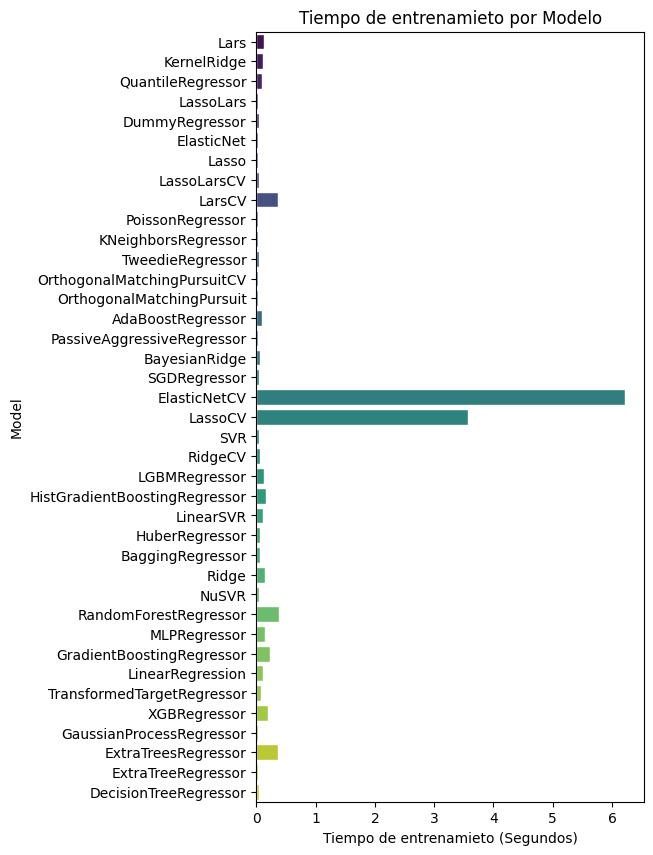

In [18]:
# Graficamos el tiempo que le tomó el entrenamiento a cada modelo
plt.figure(figsize=(5, 10))
plt.xlabel('Tiempo de entrenamieto (Segundos)', fontsize=10)
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train, palette="viridis")
ax.set_title(label="Tiempo de entrenamieto por Modelo")

[(0.0, 1.0)]

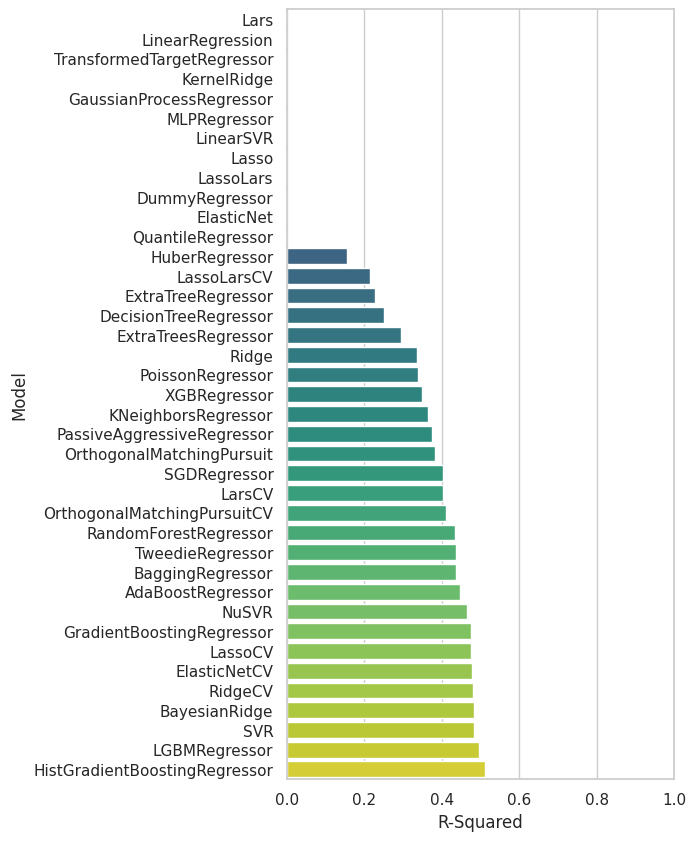

In [19]:
# Graficamos el desempeño de cada modelo de regresión
# Basados en R2
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_test.index, x="R-Squared", data=predictions_test, palette="viridis")
ax.set(xlim=(0, 1))

##### Modelos

In [20]:
# Suprimir warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt.optimizer.optimizer')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [21]:
# Definir una función para evaluar el rendimiento del modelo con métricas adicionales
def evaluate_model(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    metrics = {
        'R^2': r2_score(Y_test, Y_pred),
        'MAE': mean_absolute_error(Y_test, Y_pred),
        'MSE': mean_squared_error(Y_test, Y_pred),
        'RMSE': np.sqrt(mean_squared_error(Y_test, Y_pred)),
        'MAPE': mean_absolute_percentage_error(Y_test, Y_pred),
        'Explained Variance': explained_variance_score(Y_test, Y_pred),
        'Max Error': max_error(Y_test, Y_pred),
        'Median AE': median_absolute_error(Y_test, Y_pred)
    }
    return metrics

In [22]:
# Definir una función para optimizar los hiperparámetros
def optimize_hyperparameters(model_type, space, n_calls=10, random_state=42):
    @use_named_args(space)
    def objective_function(**params):
        if model_type == 'RandomForest':
            model = RandomForestRegressor(**params, random_state=random_state, n_jobs=-1)
        elif model_type == 'SVR':
            model = SVR(**params)
        elif model_type == 'KNeighbors':
            model = KNeighborsRegressor(**params, n_jobs=-1)
        else:
            raise ValueError(f"Modelo no válido: {model_type}")

        # Usar validación cruzada para evaluar el modelo con múltiples núcleos
        score = cross_val_score(model, X_train, Y_train, cv=3, n_jobs=-1, scoring='r2').mean()
        return -score  # Minimizar el negativo de R²

    result = gp_minimize(objective_function, space, n_calls=n_calls, random_state=random_state)
    return result

In [23]:
# Imprimir los resultados
def print_metrics(model_name, metrics):
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    print(df_metrics)

In [24]:
# Ajustar los espacios de búsqueda para cada modelo
rf_space = [
    Integer(170, 190, name='n_estimators'),
    Integer(12, 16, name='max_depth'),
]

svr_space = [
    Real(1e1, 1e3, name='C'),
    Real(1e-2, 1e2, name='gamma')
]

knn_space = [
    Integer(2, 6, name='n_neighbors'),
    Integer(1, 2, name='p'),  # 1 para Manhattan, 2 para Euclidean
]

In [25]:
# Optimizar y entrenar los modelos con un mayor número de llamadas
rf_result = optimize_hyperparameters('RandomForest', rf_space)
rf_best_params = dict(zip([dim.name for dim in rf_space], rf_result.x))
rf_model = RandomForestRegressor(**rf_best_params, random_state=42)
rf_model.fit(X_train, Y_train)
rf_metrics = evaluate_model(rf_model, X_test, Y_test)

svr_result = optimize_hyperparameters('SVR', svr_space)
svr_best_params = dict(zip([dim.name for dim in svr_space], svr_result.x))
svr_model = SVR(**svr_best_params)
svr_model.fit(X_train, Y_train)
svr_metrics = evaluate_model(svr_model, X_test, Y_test)

knn_result = optimize_hyperparameters('KNeighbors', knn_space)
knn_best_params = dict(zip([dim.name for dim in knn_space], knn_result.x))
knn_model = KNeighborsRegressor(**knn_best_params)
knn_model.fit(X_train, Y_train)
knn_metrics = evaluate_model(knn_model, X_test, Y_test)

In [26]:
# Mostrar mejores hiperparámetros para cada modelo
print("Random Forest Best Parameters:", rf_best_params)
print("SVR Best Parameters:", svr_best_params)
print("KNeighbors Best Parameters:", knn_best_params)

Random Forest Best Parameters: {'n_estimators': 190, 'max_depth': 14}
SVR Best Parameters: {'C': 939.1671819255929, 'gamma': 0.0878687964430227}
KNeighbors Best Parameters: {'n_neighbors': 2, 'p': 2}


In [27]:
# Imprimir métricas para cada modelo
rf_metrics

{'R^2': 0.43206824842730707,
 'MAE': 0.10951638273306855,
 'MSE': 0.02569941700892183,
 'RMSE': 0.16031037710928706,
 'MAPE': 10678668474171.404,
 'Explained Variance': 0.43744644166307556,
 'Max Error': 0.6865554744718014,
 'Median AE': 0.06816329402534052}

In [28]:
# Imprimir métricas para cada modelo
svr_metrics

{'R^2': 0.3876089252232995,
 'MAE': 0.12415497507803604,
 'MSE': 0.027711240936339598,
 'RMSE': 0.16646693646589283,
 'MAPE': 14041146765951.252,
 'Explained Variance': 0.3939672083702084,
 'Max Error': 0.6319318823120061,
 'Median AE': 0.09212366193379218}

In [29]:
# Imprimir métricas para cada modelo
knn_metrics

{'R^2': 0.3005898858720045,
 'MAE': 0.11754251134040568,
 'MSE': 0.03164892988190732,
 'RMSE': 0.17790146115731403,
 'MAPE': 5608498299098.836,
 'Explained Variance': 0.3403047117746756,
 'Max Error': 0.6395744667649746,
 'Median AE': 0.06025767775430907}

In [30]:
# Graficar la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Obtener las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, random_state=42)

    # Calcular medias y desviaciones estándar
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    # Área de la desviación estándar
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Curvas de media
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

*Curva de Aprendizaje*



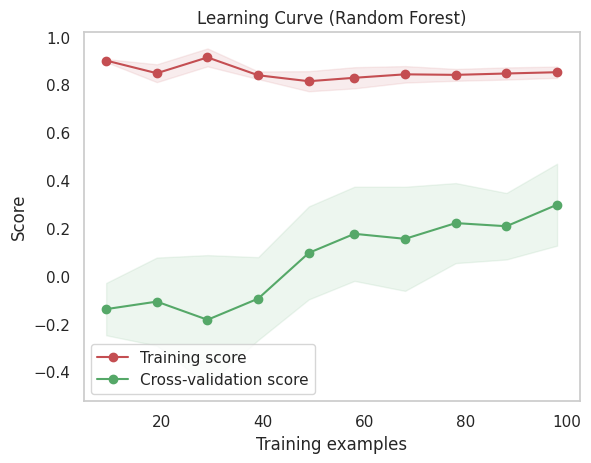

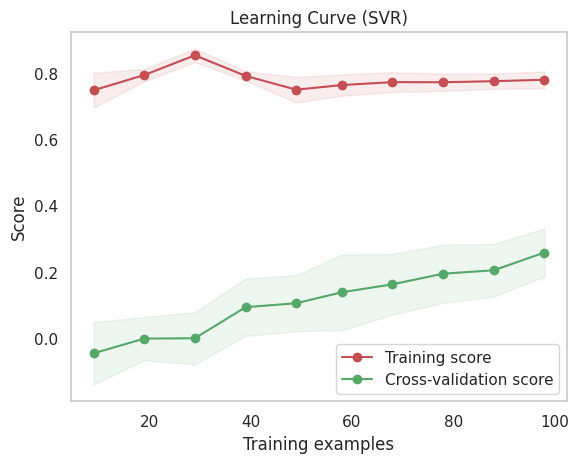

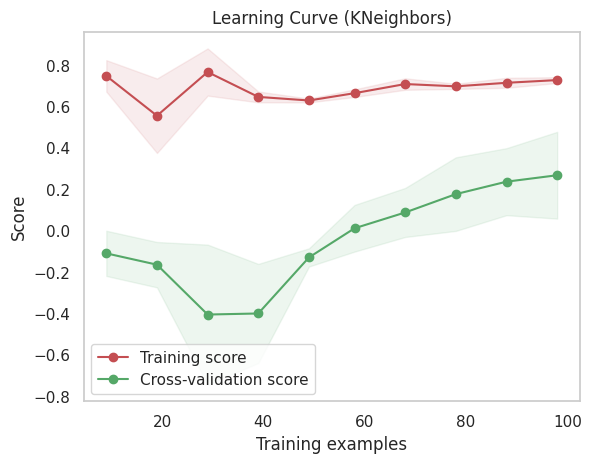

In [31]:
# Graficar la curva de aprendizaje para cada modelo
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, Y_train, cv=3)
plt.show()

plot_learning_curve(svr_model, "Learning Curve (SVR)", X_train, Y_train, cv=3)
plt.show()

plot_learning_curve(knn_model, "Learning Curve (KNeighbors)", X_train, Y_train, cv=3)
plt.show()